# Explore here

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import os
import joblib

## Paso 1: Carga del conjunto de datos

In [44]:
# Cargar conjunto de datos
url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
df = pd.read_csv(url)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [45]:
# Guardar en la carpeta data/raw
df.to_csv("../data/raw/df.csv", index = False)

## Paso 2: Realiza un EDA completo

In [46]:
# Conocer las dimensiones de los datos
df.shape

(768, 9)

In [47]:
# Obtener la información sobre tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- El conjunto de datos no contiene valores nulos.
- Todas las variables son numéricas.

In [48]:
# Ver lo número de valores únicos
df.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [49]:
# Comprobar si hay filas duplicadas
df.duplicated().sum()

np.int64(0)

In [50]:
# Conteo de valores únicos en la variable objetivo Outcome
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

Voy revisar cuántos ceros hay en algunas columnas donde sospecho que un valor de cero podría representar datos ausentes o erróneos. Por ejemplo, una persona no puede tener una presión arterial igual a 0. 

In [51]:
# Ver cuántos ceros hay
columnas_con_ceros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columnas_con_ceros].isin([0]).sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Hay muchos valores iguales a 0 y, como el conjunto de datos no es muy grande, he decidido reemplazarlos por la mediana de cada columna.

In [52]:
# Reemplazo de ceros por NaN
df[columnas_con_ceros] = df[columnas_con_ceros].replace(0, np.nan)

# Imputación con la mediana
df.fillna(df.median(), inplace=True)

In [53]:
df[columnas_con_ceros].isin([0]).sum()

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


## Paso 3: Construye un modelo de árbol de decisión

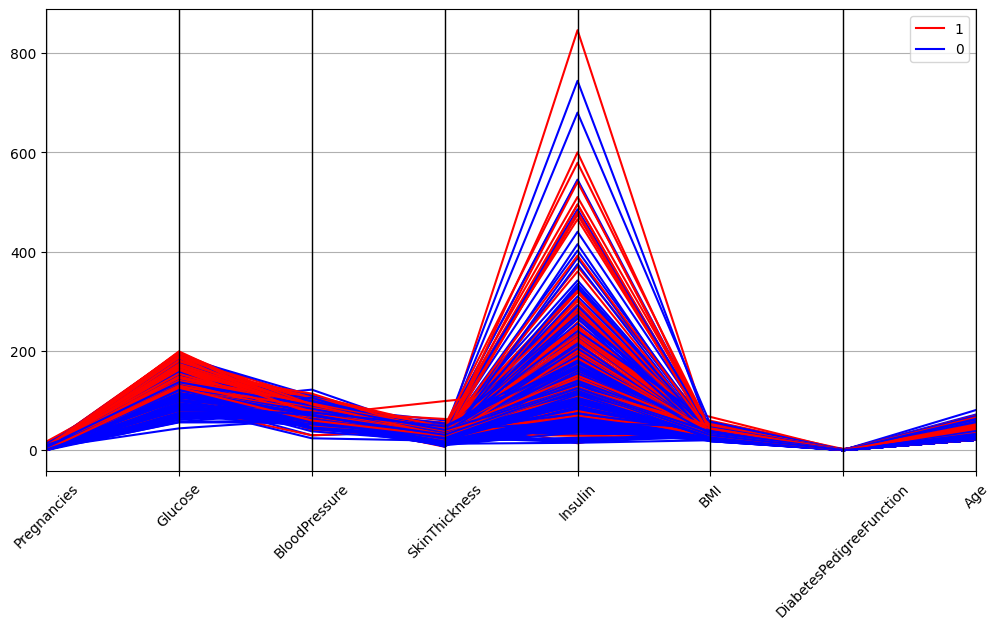

In [55]:
# Visualizamos la relación entre las características de nuestro dataset
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

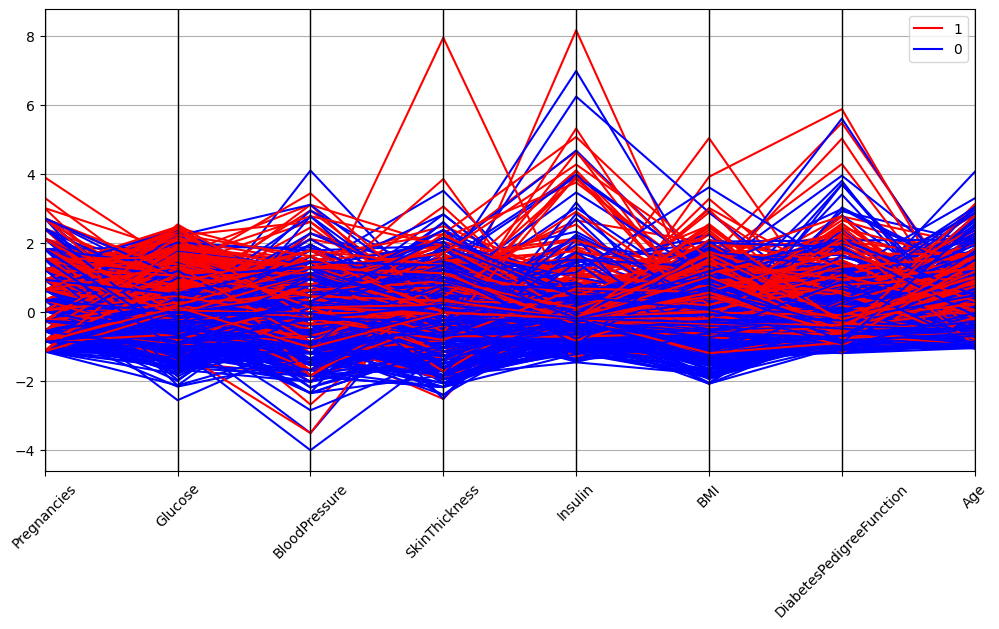

In [56]:
# Visualizamos la relación entre las características de nuestro dataset escalado
data_sc = pd.DataFrame(data=StandardScaler().fit_transform(df.drop(['Outcome'], axis=1)), columns=df.columns[:-1])
data_sc['Outcome'] = df.Outcome
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(data_sc, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Outcome'],axis=1), df['Outcome'], test_size=0.2, random_state=42)

In [58]:
X_train.shape

(614, 8)

In [59]:
X_test.shape

(154, 8)

In [60]:
# Guardar los datasets procesados
os.makedirs('data/processed', exist_ok=True)
X_train.to_csv('data/processed/X_train.csv', index=False)
X_test.to_csv('data/processed/X_test.csv', index=False)
y_train.to_csv('data/processed/y_train.csv', index=False)
y_test.to_csv('data/processed/y_test.csv', index=False)

## Árbol de decisión

In [61]:
# Arbol de decisión simple
simple_tree = DecisionTreeClassifier(max_depth=3, max_features=X_train.shape[1]//2, min_samples_leaf=20, min_samples_split=30, random_state=42)
simple_tree.fit(X_train, y_train)

# Arbol de decisión complejo
complex_tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1, random_state=42)
complex_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=100, random_state=42)

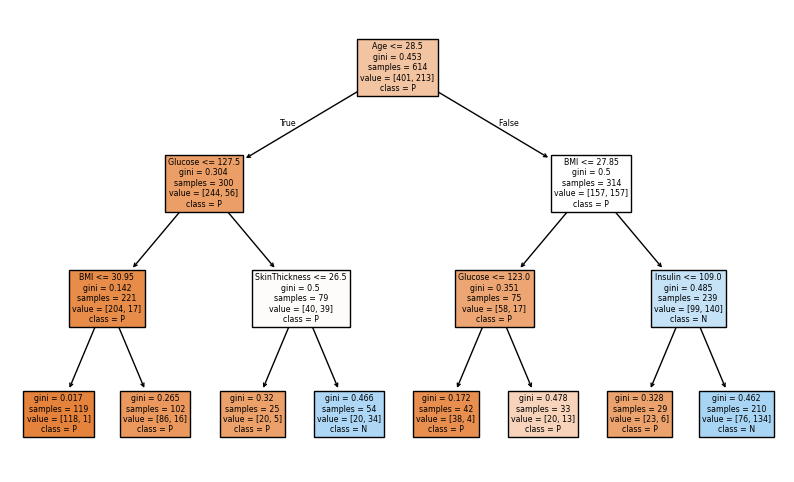

In [62]:
# Visualiza el árbol de decisión simple gráficamente
plt.figure(figsize=(10, 6))
plot_tree(simple_tree, feature_names=X_train.columns, class_names=['P','N'], filled=True)
plt.show()

In [63]:
X_train[(X_train['Age'] > 28.5) & (X_train['BMI'] <= 27.85)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
294,0,161.0,50.0,29.0,125.0,21.9,0.254,65
306,10,161.0,68.0,23.0,132.0,25.5,0.326,47
44,7,159.0,64.0,29.0,125.0,27.4,0.294,40
28,13,145.0,82.0,19.0,110.0,22.2,0.245,57
319,6,194.0,78.0,29.0,125.0,23.5,0.129,59
...,...,...,...,...,...,...,...,...
243,6,119.0,50.0,22.0,176.0,27.1,1.318,33
475,0,137.0,84.0,27.0,125.0,27.3,0.231,59
459,9,134.0,74.0,33.0,60.0,25.9,0.460,81
276,7,106.0,60.0,24.0,125.0,26.5,0.296,29


In [64]:
# Interpretación del árbol simple en texto plano
text_representation = export_text(simple_tree, feature_names=list(X_train.columns))
print(text_representation)

|--- Age <= 28.50
|   |--- Glucose <= 127.50
|   |   |--- BMI <= 30.95
|   |   |   |--- class: 0
|   |   |--- BMI >  30.95
|   |   |   |--- class: 0
|   |--- Glucose >  127.50
|   |   |--- SkinThickness <= 26.50
|   |   |   |--- class: 0
|   |   |--- SkinThickness >  26.50
|   |   |   |--- class: 1
|--- Age >  28.50
|   |--- BMI <= 27.85
|   |   |--- Glucose <= 123.00
|   |   |   |--- class: 0
|   |   |--- Glucose >  123.00
|   |   |   |--- class: 0
|   |--- BMI >  27.85
|   |   |--- Insulin <= 109.00
|   |   |   |--- class: 0
|   |   |--- Insulin >  109.00
|   |   |   |--- class: 1



**Hallazgos**

- Edad fue la variable más importante (Corte en 28,5 años).
- Personas jóvenes (≤ 28,5 años):
    Si glucosa ≤ 127,5, predice no diabetes.
    Si glucosa alta y grosor de piel > 26,5, predice diabetes.
- En jóvenes, glucosa alta + mayor grasa subcutánea = posible indicador de riesgo.

In [65]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

## Predicciones de los dos árboles

In [66]:
# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = complex_tree.predict(X_train)
test_pred_complex = complex_tree.predict(X_test)

# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = simple_tree.predict(X_train)
test_pred_simple = simple_tree.predict(X_test)

## Métricas

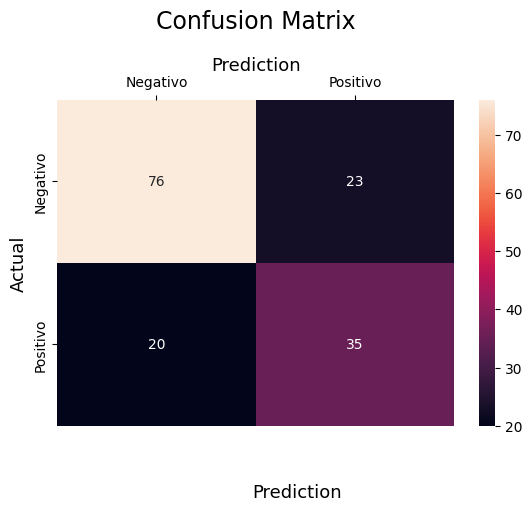

In [67]:
# Matriz de confusión
cm = confusion_matrix(y_test,test_pred_complex)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negativo','Positivo'],
            yticklabels=['Negativo','Positivo'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

**Hallazgos**

- 76 verdaderos negativos: sin diabetes correctamente clasificados.
- 35 verdaderos positivos: con diabetes correctamente clasificados.
- 23 falsos positivos: sin diabetes pero clasificados como positivos.
- 20 falsos negativos: con diabetes pero clasificados como negativos.

In [68]:
# Métricas del modelo complejo
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
Test,0.720779,0.619469,0.70202,0.603448,0.636364,0.767677
Diferencia,0.279221,0.380531,0.29798,0.396552,0.363636,0.232323


In [69]:
# Métricas del modelo simple
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.770358,0.704403,0.774665,0.636364,0.788732,0.760599
Test,0.688312,0.652174,0.717172,0.542169,0.818182,0.616162
Diferencia,0.082047,0.052229,0.057494,0.094195,-0.029449,0.144437


**Hallazgos**

- El modelo complejo muestra mejor desempeño en entrenamiento, pero baja generalización en test.
- El modelo simple tiene mejor F1 y AUC en test, lo que indica mejor equilibrio entre precisión y recall.
- El recall del modelo simple es más alto, lo que lo hace más efectivo para detectar casos positivos.

En conclusión, el modelo simple parece una mejor opción por su mayor capacidad de generalización y mayor recall en test.

In [70]:
simple_tree.predict_proba(X_train)

array([[0.84313725, 0.15686275],
       [0.36190476, 0.63809524],
       [0.8       , 0.2       ],
       ...,
       [0.36190476, 0.63809524],
       [0.36190476, 0.63809524],
       [0.99159664, 0.00840336]], shape=(614, 2))

## Paso 4: Optimiza el modelo

In [71]:
# Instancia del modelo
dtc = DecisionTreeClassifier(random_state=42)

In [72]:
# Definir hiperparametros
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10, None], # profundidad máxima del árbol
    'min_samples_split': [2, 5, 10], # mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4] # mínimo de muestras por hoja
}

In [73]:
# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=1)

In [74]:
# Ver los mejores resultados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor score de F1 en validación:")
print(grid_search.best_score_)

Mejores hiperparámetros encontrados:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}

Mejor score de F1 en validación:
0.643547161156655


In [75]:
# Modelo decision tree con parametros optimizados
best_dtc = grid_search.best_estimator_
best_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

In [76]:
# Predicciones
y_train_pred = best_dtc.predict(X_train)
y_test_pred = best_dtc.predict(X_test)

## Evaluacion del modelo

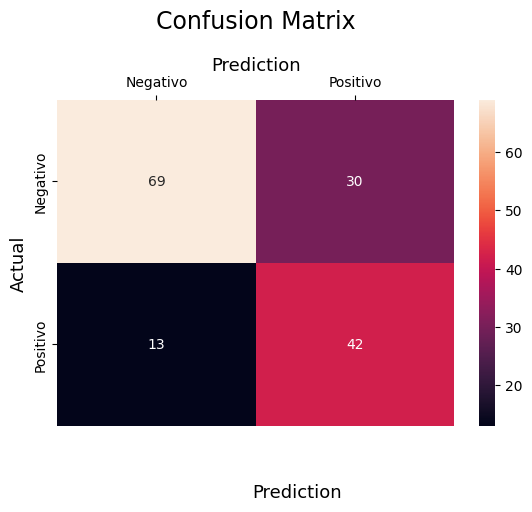

In [77]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negativo','Positivo'],
            yticklabels=['Negativo','Positivo'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [78]:
# Calculo el accuract en train y test
train_acc = accuracy_score(y_true=y_train, y_pred=y_train_pred)
test_acc = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("Accuracy en train:", round(train_acc, 3))
print("Accuracy en test :", round(test_acc, 3))

Accuracy en train: 0.826
Accuracy en test : 0.721


In [79]:
# Reporte de clasificación
print("\nReporte en test:")
print(classification_report(y_test, y_test_pred, target_names=["Negativo", "Positivo"]))


Reporte en test:
              precision    recall  f1-score   support

    Negativo       0.84      0.70      0.76        99
    Positivo       0.58      0.76      0.66        55

    accuracy                           0.72       154
   macro avg       0.71      0.73      0.71       154
weighted avg       0.75      0.72      0.73       154



**Conclusiones**
- El modelo optimizado generaliza mejor (accuracy más alto en test).
- Tiene mejor balance entre precisión y recall.
- La matriz de confusión muestra mejor detección de positivos con menos errores.

## Paso 5: Guarda el modelo

In [80]:
# Crear carpeta
os.makedirs('artifacts', exist_ok=True)

# Guardar modelo optimizado
joblib.dump(best_dtc, 'artifacts/decision_tree_optimized.pkl')


['artifacts/decision_tree_optimized.pkl']